<a href="https://colab.research.google.com/github/betogaona7/Distracted_Driver_Detection/blob/master/Distracted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect with Drive

In [0]:
from google.colab import drive
drive.mount("/betogaona7")

In [0]:
%cd ./../betogaona7/My\ Drive/app/Distracted

## Imports 

In [0]:
import os 
import random
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import csv

import tensorflow as tf

## Create train and validation TFRecord files

In [0]:
def imgs_with_labels(src):
  data = []
  total = 0
  for path, subdir, files in os.walk(src):
    for file in files:
      if file[-3:] == 'jpg': 
        data.append((os.path.join(path, file), path[-1:]))
      total += 1
  return data, total

data, total = imgs_with_labels("./data/test/")

In [0]:
print(total)
img_path, label = data[random.randint(0, total)]
print("img: ", img_path, " label: ", label, " total: ", total )

In [0]:
print(data[:10])
random.shuffle(data)
print(data[:10])

In [0]:
total = 22424

tsize = int(0.8*total)+1
vsize = int(0.2*total)

train_data = data[:tsize]
valid_data = data[-vsize:]

print(len(train_data), len(valid_data), tsize+vsize)
print(train_data[-10:])
print(valid_data[:10])

In [0]:
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def create_tf_record(tfr_name, data):
  writer = tf.python_io.TFRecordWriter(tfr_name)
  i = 1
  for img_path, img_class in data:
    img = np.array(Image.open(img_path))

    img_raw = open(img_path, 'rb').read()
    label = int(img_class)
    path = str.encode(img_path)

    example = tf.train.Example(features=tf.train.Features(feature={
        'image': _bytes_feature(img_raw),
        'label': _int64_feature(label),
        'height': _int64_feature(img.shape[0]),
        'width': _int64_feature(img.shape[1]),
        'depth': _int64_feature(img.shape[2]),
        'path': _bytes_feature(path) }))
    writer.write(example.SerializeToString())
    if(i%100 == 0):
        print(i)
    i+= 1
  writer.close()
  
#create_tf_record("train2.tfrecord", train_data)
#create_tf_record("valid2.tfrecord", valid_data)


In [0]:
for example in tf.python_io.tf_record_iterator("train.tfrecord"):
  result = tf.train.Example.FromString(example)
print(result)

In [0]:
!du -lh valid.tfrecord
!du -lh train.tfrecord
!du -sh ./data/train/

91M	valid.tfrecord
820M	train.tfrecord
913M	./data/train/


In [0]:
!du -lh test.tfrecord

du: cannot access 'test.tfrecord': No such file or directory


## Build dataset 

In [0]:
def StateFarmDataset(image_size, tfrecord_file, shuffle_buffer_size, batch_size):
  img_size = tf.cast(image_size, tf.int32)
  
  def _parse_function(example):
    features = {'label': tf.FixedLenFeature((), tf.int64),
                'image': tf.FixedLenFeature((), tf.string),
                'height': tf.FixedLenFeature((), tf.int64),
                'width': tf.FixedLenFeature((), tf.int64),
                'depth': tf.FixedLenFeature((), tf.int64),
                'path': tf.FixedLenFeature((), tf.string)}
    parsed_features = tf.parse_single_example(example, features)
    
    # Reconstruct image 
    image = tf.image.decode_jpeg(parsed_features['image'], 3)
    img_shape = tf.stack([tf.cast(parsed_features['height'], tf.int32),
                          tf.cast(parsed_features['width'], tf.int32),
                          tf.cast(parsed_features['depth'], tf.int32)])
    image = tf.reshape(image, img_shape)
    
    # Normalize the image in the range 0 to 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Reshape image 
    image = tf.image.resize(image, [image_size, image_size])
        
    # One-hot encoding
    label = tf.one_hot(parsed_features['label'], 10, dtype=tf.int32)
    
    return image, label, parsed_features['path']
  
  dataset = tf.data.TFRecordDataset(tfrecord_file)
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(_parse_function)
  
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  
  return dataset         

In [6]:
total = 22424
dataset = StateFarmDataset(64, "train2.tfrecord", total, 1)
print(dataset)

<DatasetV1Adapter shapes: ((?, 64, 64, ?), (?, 10), (?,)), types: (tf.float32, tf.int32, tf.string)>


Label:  [[0 0 0 0 0 0 1 0 0 0]]
Img path:  [b'./data/train/c6/img_97195.jpg']
Img shape:  (1, 64, 64, 3)
Fine.


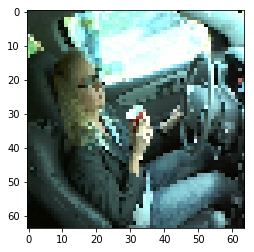

In [7]:
def test_normalization(image):
  assert image.max() <= 1 and image.min() >= 0,\
        'Incorect Range. {} to {} found'.format(image().min(), image.to_numpy().max())
  print("Fine.")
    


iterator = dataset.make_one_shot_iterator()
record = iterator.get_next()
with tf.Session() as sess:
  img, label, img_path = sess.run(record)
  print("Label: ", label)
  print("Img path: ", img_path)
  print("Img shape: ", img.shape)
  test_normalization(img[0])
  #print(img)
  plt.imshow(img[0])

In [9]:
train_samples = 17943
valid_samples =  4481
img_size = 64
batch_size = 128

train_dataset = StateFarmDataset(img_size, "train2.tfrecord", train_samples, batch_size)
valid_dataset = StateFarmDataset(img_size, "valid2.tfrecord", valid_samples, valid_samples)

handle = tf.placeholder(tf.string, shape=[])
train_iterator = tf.data.Iterator.from_string_handle(handle, train_dataset.output_types, train_dataset.output_shapes)
next_train_elements = train_iterator.get_next()
train_iter = train_dataset.make_initializable_iterator()

valid_iterator = valid_dataset.make_one_shot_iterator()
next_valid_elements = valid_iterator.get_next()


print("Samples in training: ", train_samples, "Number of trainining mini-batches: ", int(train_samples/batch_size))
print("Samples in validation: ", valid_samples, "Number of validation mini-batches: ", int(valid_samples/valid_samples))

Samples in training:  17943 Number of trainining mini-batches:  140
Samples in validation:  4481 Number of validation mini-batches:  1


## Build network

In [0]:
def nn_input(img_shape):
  return tf.placeholder(tf.float32, shape=[None, img_shape[0], img_shape[1], img_shape[2]], name="x")

def nn_label(n_classes):
  return tf.placeholder(tf.float32, shape=[None, n_classes], name='y')

def nn_keep_prob():
  return tf.placeholder(tf.float32, name='keep_prob')

def conv2d_maxpool(x_tensor, outs, conv_ksize, conv_strides, pool_ksize, pool_strides):
  weights = tf.Variable(tf.truncated_normal([conv_ksize, conv_ksize, int(x_tensor.shape[3]), outs]))
  bias = tf.Variable(tf.zeros([outs]))
  
  x = tf.nn.conv2d(x_tensor, weights, strides=[1, conv_strides, conv_strides, 1], padding="SAME")
  x = tf.nn.bias_add(x, bias)
  x = tf.nn.relu(x)
  x = tf.nn.max_pool(x, ksize=[1, pool_ksize, pool_ksize, 1], strides=[1, pool_strides, pool_strides, 1], padding="SAME")
  return x

def flatten(x_tensor):
  dimensions = x_tensor.get_shape().as_list()
  img_flat_size = dimensions[1] * dimensions[2] * dimensions[3]
  return tf.reshape(x_tensor, [-1, img_flat_size])

def dense(x_tensor, n_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), n_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([n_outputs]))
  
  x = tf.add(tf.matmul(x_tensor, weights), bias)
  x = tf.nn.relu(x)
  return x

def nn_output(x_tensor, n_outputs):
  weights = tf.Variable(tf.truncated_normal([int(x_tensor.shape[-1]), n_outputs], mean=0.0, stddev=0.1))
  bias = tf.Variable(tf.zeros([n_outputs]))
  
  x = tf.add(tf.matmul(x_tensor, weights), bias)
  return x

### Unit tests

In [0]:
def test_nn_input(neural_net_image_input):
    image_shape = (64, 64, 3)
    nn_inputs_out_x = nn_input(image_shape)

    assert nn_inputs_out_x.get_shape().as_list() == [None, image_shape[0], image_shape[1], image_shape[2]],\
        'Incorrect Image Shape.  Found {} shape'.format(nn_inputs_out_x.get_shape().as_list())

    assert nn_inputs_out_x.op.type == 'Placeholder',\
        'Incorrect Image Type.  Found {} type'.format(nn_inputs_out_x.op.type)

    assert nn_inputs_out_x.name == 'x:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_x.name)

    print("Image input tests passed.")


def test_nn_label(neural_net_label_input):
    n_classes = 10
    nn_inputs_out_y = nn_label(n_classes)

    assert nn_inputs_out_y.get_shape().as_list() == [None, n_classes],\
        'Incorrect Label Shape.  Found {} shape'.format(nn_inputs_out_y.get_shape().as_list())

    assert nn_inputs_out_y.op.type == 'Placeholder',\
        'Incorrect Label Type.  Found {} type'.format(nn_inputs_out_y.op.type)

    assert nn_inputs_out_y.name == 'y:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_y.name)

    print("Label input tests passed.")
    
def test_nn_keep_prob(neural_net_keep_prob_input):
    nn_inputs_out_k = nn_keep_prob()

    assert nn_inputs_out_k.get_shape().ndims is None,\
        'Too many dimensions found for keep prob.  Found {} dimensions.  It should be a scalar (0-Dimension Tensor).'.format(nn_inputs_out_k.get_shape().ndims)

    assert nn_inputs_out_k.op.type == 'Placeholder',\
        'Incorrect keep prob Type.  Found {} type'.format(nn_inputs_out_k.op.type)

    assert nn_inputs_out_k.name == 'keep_prob:0', \
        'Incorrect Name.  Found {}'.format(nn_inputs_out_k.name)
    
    print("Keep prob tests passed.")
    
def test_conv2d_maxpool(conv2d_maxpool):
    test_x = tf.placeholder(tf.float32, [None, 64, 64, 5])
    test_num_outputs = 10
    test_con_k = 2
    test_con_s = 4
    test_pool_k = 2
    test_pool_s = 2

    conv2d_maxpool_out = conv2d_maxpool(test_x, test_num_outputs, test_con_k, test_con_s, test_pool_k, test_pool_s)

    assert conv2d_maxpool_out.get_shape().as_list() == [None, 8, 8, 10],\
        'Incorrect Shape.  Found {} shape'.format(conv2d_maxpool_out.get_shape().as_list())

    print("Conv layer test passed.")
    
def test_flatten(flatten):
    test_x = tf.placeholder(tf.float32, [None, 10, 30, 6])
    flat_out = flatten(test_x)

    assert flat_out.get_shape().as_list() == [None, 10*30*6],\
        'Incorrect Shape.  Found {} shape'.format(flat_out.get_shape().as_list())

    print("Flatten test passed.")
    
def test_dense(fully_conn):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    fc_out = fully_conn(test_x, test_num_outputs)

    assert fc_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(fc_out.get_shape().as_list())

    print("Dense layer test passed.")


def test_output(output):
    test_x = tf.placeholder(tf.float32, [None, 128])
    test_num_outputs = 40

    output_out = output(test_x, test_num_outputs)

    assert output_out.get_shape().as_list() == [None, 40],\
        'Incorrect Shape.  Found {} shape'.format(output_out.get_shape().as_list())

    print("Output test passed")

test_nn_input(nn_input)
test_nn_label(nn_label)
test_nn_keep_prob(nn_keep_prob)
test_conv2d_maxpool(conv2d_maxpool)
test_flatten(flatten)
test_dense(dense)
test_output(nn_output)

Image input tests passed.
Label input tests passed.
Keep prob tests passed.
Conv layer test passed.
Flatten test passed.
Dense layer test passed.
Output test passed


In [0]:
def model(x, keep_prob):
  conv1 = conv2d_maxpool(x, 128, 3, 1, pool_ksize=2, pool_strides=2)
  conv2 = conv2d_maxpool(conv1, 64, 3, 1, pool_ksize=2, pool_strides=2)
  conv3 = conv2d_maxpool(conv2, 32, 3, 1, pool_ksize=2, pool_strides=2)
  conv4 = conv2d_maxpool(conv3, 16, 3, 1, pool_ksize=2, pool_strides=2)
  
  fc1 = flatten(conv4)
  fc1 = dense(fc1, 1024)
  
  out = nn_output(fc1, 10)
  return out 

x = nn_input((64, 64, 3))
y = nn_label(10)
keep_prob = nn_keep_prob()

logits = model(x, keep_prob)
logits = tf.identity(logits, name="logits")

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")

In [0]:
def test_model(model):
    test_x = tf.placeholder(tf.float32, [None, 64, 64, 3])
    test_k = tf.placeholder(tf.float32)

    logits_out = model(test_x, test_k)

    assert logits_out.get_shape().as_list() == [None, 10],\
        'Incorrect Model Output.  Found {}'.format(logits_out.get_shape().as_list())

    print("Model test passed.")
    
test_model(model)

Model test passed.


## Train

In [12]:
if not tf.test.gpu_device_name():
  print("You don't have the GPU activated")
else:
  print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


### Single optimization

In [0]:
def train_nn(session, optimizer, keep_probability, feature_batch, label_batch):
  return session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob:keep_probability})

def print_stats(session, feature_batch, label_batch, cost, accuracy):
  loss = sess.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
  
  valid_acc = sess.run(accuracy, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.})
  print("Loss: {:>10.4f} Validation accuracy: {:.6f}".format(loss, valid_acc))
  return None

In [0]:
from unittest.mock import MagicMock

def test_train_nn(train_neural_network):
    mock_session = tf.Session()
    test_x = np.random.rand(128, 64, 64, 3)
    test_y = np.random.rand(128, 10)
    test_k = np.random.rand(1)
    test_optimizer = tf.train.AdamOptimizer()

    mock_session.run = MagicMock()
    train_neural_network(mock_session, test_optimizer, test_k, test_x, test_y)

    assert mock_session.run.called, 'Session not used'

    print("Training test passed.")
    
test_train_nn(train_nn)

Training test passed.


In [0]:
epochs = 15 
keep_probability = 1.0

In [0]:
print("Checking training on a single mini batch... ")

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  
  train_handle = sess.run(train_iter.string_handle())
  sess.run(train_iter.initializer)
  
  valid_features, valid_labels,_ = sess.run(next_valid_elements)
  features, labels, _ = sess.run(next_train_elements, feed_dict={handle: train_handle}) # First mini batch
  
  for epoch in range(epochs):
    batch_i = 1
    train_nn(sess, optimizer, keep_probability, features, labels)
    print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, batch_i), end='')
    print_stats(sess, valid_features, valid_labels, cost, accuracy)

Checking training on a single mini batch... 
Epoch  1, Batch 1:  

## Full train

In [0]:
print("Training...")

with tf.Session() as  sess:
  sess.run(tf.global_variables_initializer())
  
  train_handle = sess.run(train_iter.string_handle())
  
  
  valid_features, valid_labels,_ = sess.run(next_valid_elements)
  
  for epoch in range(epochs):
    sess.run(train_iter.initializer)
    for batch in range(158):
      features, labels, _ = sess.run(next_train_elements, feed_dict={handle: train_handle})
      train_nn(sess, optimizer, keep_probability, features, labels)
    print('Epoch {:>2}, Batch {}:  '.format(epoch + 1, 1), end='')
    print_stats(sess, valid_features, valid_labels, cost, accuracy)
    
  saver = tf.train.Saver()
  save_path = saver.save(sess, "./model")

Epoch  2, Batch 1:  Loss:   152.9061 Validation accuracy: 0.748885
Epoch  3, Batch 1:  Loss:    99.1391 Validation accuracy: 0.830508
Epoch  4, Batch 1:  Loss:    83.0813 Validation accuracy: 0.844781
Epoch  5, Batch 1:  Loss:    61.5902 Validation accuracy: 0.884478
Epoch  6, Batch 1:  Loss:    60.7555 Validation accuracy: 0.893399
Epoch  7, Batch 1:  Loss:    65.3486 Validation accuracy: 0.884032
Epoch  8, Batch 1:  Loss:    58.1882 Validation accuracy: 0.893845
Epoch  9, Batch 1:  Loss:    68.6058 Validation accuracy: 0.876896
Epoch 10, Batch 1:  Loss:    40.7528 Validation accuracy: 0.921053
Epoch 11, Batch 1:  Loss:    40.5651 Validation accuracy: 0.919715
Epoch 12, Batch 1:  Loss:    47.2211 Validation accuracy: 0.918822
Epoch 13, Batch 1:  Loss:    36.6121 Validation accuracy: 0.931311
Epoch 14, Batch 1:  Loss:    37.8650 Validation accuracy: 0.937110
Epoch 15, Batch 1:  Loss:    40.6515 Validation accuracy: 0.935326
Epoch 16, Batch 1:  Loss:    33.6616 Validation accuracy: 0.94

## Evaluate

In [0]:
for example in tf.python_io.tf_record_iterator("test.tfrecord"):
  result = tf.train.Example.FromString(example)
print(result)

In [0]:
def get_test_data(image_size, tfrecord_file, batch_size):
  img_size = tf.cast(image_size, tf.int32)
  
  def _parse_function(example):
    features = {'image': tf.FixedLenFeature((), tf.string),
                'height': tf.FixedLenFeature((), tf.int64),
                'width': tf.FixedLenFeature((), tf.int64),
                'depth': tf.FixedLenFeature((), tf.int64),
                'path': tf.FixedLenFeature((), tf.string)}
    parsed_features = tf.parse_single_example(example, features)
    
    # Reconstruct image 
    image = tf.image.decode_jpeg(parsed_features['image'], 3)
    img_shape = tf.stack([tf.cast(parsed_features['height'], tf.int32),
                          tf.cast(parsed_features['width'], tf.int32),
                          tf.cast(parsed_features['depth'], tf.int32)])
    image = tf.reshape(image, img_shape)
    
    # Normalize the image in the range 0 to 1
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # Reshape image 
    image = tf.image.resize(image, [image_size, image_size])
    
    return image, parsed_features['path']
  
  dataset = tf.data.TFRecordDataset(tfrecord_file)
  dataset = dataset.map(_parse_function)
  
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  
  return dataset        

test_data = get_test_data(64, "test.tfrecord", 128)
print(test_data)

<DatasetV1Adapter shapes: ((?, 45, 60, ?), (?,)), types: (tf.float32, tf.string)>


### Display a single test image

In [0]:
iterator = test_data.make_one_shot_iterator()
record = iterator.get_next()
with tf.Session() as sess:
  img, img_path = sess.run(record)
  print("Img path: ", img_path)
  print("Img shape: ", img.shape)
  plt.imshow(img[0])

### Build test iterator

In [0]:
test_dataset = get_test_data(64, "test.tfrecord", 1)

handle = tf.placeholder(tf.string, shape=[])

test_iterator = tf.data.Iterator.from_string_handle(handle, test_dataset.output_types, test_dataset.output_shapes)
next_test_elements = train_iterator.get_next()
test_iter = test_dataset.make_initializable_iterator()

In [0]:
save_model_path="./model"
n_samples = 3
top_n_predictions = 3

def get_predictions():
  img_predictionsp = []
  loaded_graph = tf.Graph()
  with tf.Session(graph=loaded_graph) as sess:
    # Load model 
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, saved_model_path)
    
    # Get tensor from loaded model
    loaded_x = loaded_graph.get_tensor_by_name("x:0")
    loaded_y = loaded_graph.get_tensor_by_name("y:0")
    loaded_keep_prob = loaded_graph.get_tensor_by_name("keep_prob:0")
    loaded_logits = loaded_graph.get_tensor_by_name("logits:0")
    loaded_acc = loaded_graph.get_tensor_by_name("accuracy:0")
    
    # Initialize batch iterator
    test_handle = sess.run(test_iter.string_handle())
    sess.run(test_iter.initializer)
    
    for testsample in range(79726):
      image, image_name = sess.run(next_test_elements, feed_dict={handle: test_handle})
      image_predictions = sess.run(tf.nn.softmax(loaded_logits), feed_dict={loaded_x: images,
                                                                            loaded_y: None,
                                                                            loadedl_keep_prob: 1.0}
      print(image_name,  predictions.shape)
      print(predictions)
      break
                               

### Save CSV file 

In [0]:
with open('predictions.csv', 'w', newline='') as csvfile:
  doc = csv.writer(csvfile)
  doc.writerow(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
  for i in range(79726):
    doc.writerow([t[i][0], t[i][1], t[i][2], t[i][3], t[i][4], t[i][5], t[i][6], t[i][7], t[i][8],
                  t[i][9], t[i][10], t[i][11]])